# Variational Autoencoder (VAE) for Financial Anomaly Detection

This report presents an anomaly detection system for financial time series data using a Variational Autoencoder (VAE) with LSTM architecture. The model is trained on daily trading data from the CPALL stock and evaluated for its ability to identify anomalous trading patterns.

## Objectives
- Process and analyze financial trading data
- Develop a VAE-LSTM model for anomaly detection
- Evaluate model performance for identifying market anomalies
- Visualize results with anomaly indicators

## 1. Data Preparation and Environment Setup

First, we set up the environment and load the required data. We're using CPALL stock data from a parquet file.

In [ ]:
from setup_root import *
from pathlib import Path
import os

# Setup project directories
project_root = Path(PROJECT_DIR)
data_dir = project_root / "data"

# Ensure local data directory exists
local_data_dir = Path("./data")
local_data_dir.mkdir(exist_ok=True)

tickmatch_dir = data_dir / "tickmatch"
bidask_dir = data_dir / "bidask"

tm_intra_dir = tickmatch_dir / "intraday"
ba_intra_dir = bidask_dir / "intraday"

print(f"Data directories initialized. Local data will be saved to {local_data_dir.absolute()}")

Data directories initialized. Local data will be saved to c:\Users\vps\services\projects\valueoftime\v3\data


## 2. Import Required Libraries

We import the necessary libraries for data processing, model building, and visualization.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm
from matplotlib import pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 3. Load and Process Trading Data

We load trading data for CPALL stock and process it to create daily aggregations.

In [ ]:
symbol = "CPALL"

# Load trade data from parquet file
tm_symbol_dir = tm_intra_dir / f"{symbol}.parquet"
tm_df = pd.read_parquet(tm_symbol_dir)


print(f"Loaded {len(tm_df):,} records for {symbol}")
tm_df.head()

Loaded 2,598,399 records for CPALL


,time,vol,last,net_val,date,net_vol,type,id,symbol
0,2022-01-04 09:58:00,399600,59.00,23576400.0,2022-01-04,399600,BUY,475,CPALL
1,2022-01-04 09:58:00,12400,59.00,-731600.0,2022-01-04,-12400,SELL,416,CPALL
2,2022-01-04 09:58:00,500,59.00,-29500.0,2022-01-04,-500,SELL,458,CPALL
3,2022-01-04 09:58:00,2600,59.00,-153400.0,2022-01-04,-2600,SELL,010,CPALL
4,2022-01-04 09:58:00,400,59.25,23700.0,2022-01-04,400,BUY,733,CPALL


### 3.1 Extract Daily Price Series

We extract the daily closing prices for later analysis and visualization.

In [4]:
# Extract daily last prices
daily_last = tm_df.set_index("time")["last"].resample("1D").last().dropna()

print(f"Daily price series spans from {daily_last.index.min().date()} to {daily_last.index.max().date()}")
daily_last.head()

Daily price series spans from 2022-01-04 to 2025-05-02


time
2022-01-04    59.75
2022-01-05    59.75
2022-01-06    58.50
2022-01-07    58.25
2022-01-10    58.25
Name: last, dtype: float64

### 3.2 Create Daily Trading Aggregations

We aggregate the tick data into daily metrics including volume, trade count, buy/sell volume, and average price.

In [ ]:
# Aggregate buy/sell volumes by day
vol_df = tm_df.pivot_table(index='time', values='vol', columns='type')[['BUY', 'SELL']].\
        rename(columns={'BUY': 'buy_vol', 'SELL': 'sell_vol'}).fillna(0).\
        groupby([pd.Grouper(freq='D')]).agg({'buy_vol': 'sum', 'sell_vol': 'sum'})

# Create daily aggregations of price and volume data
tm_daily = tm_df.groupby([pd.Grouper(key="time", freq="D")]).agg({
            'last': 'mean',
            'vol':'sum',
            'id':'count',
        }).\
        dropna().\
        rename({
            'last':'price_avg',
            'vol':'vol_sum',
            'id':'id_count'
        }, axis=1)

# Merge daily aggregations with buy/sell volumes
tm_daily = tm_daily.merge(vol_df, how='left', left_index=True, right_index=True)

# Save the daily data for future use
tm_daily.to_csv(local_data_dir / f"{symbol}_daily.csv")
print(f"Saved daily aggregations to {local_data_dir / f'{symbol}_daily.csv'}")


# For reproducibility, use tm_daily from the saved file instead of reloading
# Load the daily data from the saved CSV file

tm_daily = pd.read_csv(local_data_dir / f"{symbol}_daily.csv", index_col=0, parse_dates=True)
print(f"Loaded {len(tm_daily):,} records for {symbol} daily data")



tm_daily.tail()

Saved daily aggregations to data\CPALL_daily.csv


,price_avg,vol_sum,id_count,buy_vol,sell_vol
time,,,,,
2025-04-25,50.342148,15802500,5559,3.453768e+06,485745.392642
2025-04-28,49.842780,18680500,2223,2.512934e+06,901144.512292
2025-04-29,50.087638,17404400,2536,4.805459e+06,955805.920207
2025-04-30,51.178242,43361800,6609,8.908653e+06,658642.159335
2025-05-02,51.606821,36170300,4772,4.755984e+06,956034.477893


## 4. Data Splitting and Preparation for Modeling

We split the data into training and testing sets for model development.

In [6]:
# Split data into training (70%) and testing (30%) sets
n_days = len(tm_daily)
train_days = int(n_days * 0.7)
tm_daily_train = tm_daily.iloc[:train_days]
tm_daily_test = tm_daily.iloc[train_days:]

print(f"Total trading days: {n_days}")
print(f"Training set: {len(tm_daily_train)} days ({train_days/n_days:.1%})")
print(f"Test set: {len(tm_daily_test)} days ({len(tm_daily_test)/n_days:.1%})")

print("\nTraining period:")
print(f"From: {tm_daily_train.index.min().date()} to {tm_daily_train.index.max().date()}")

print("\nTest period:")
print(f"From: {tm_daily_test.index.min().date()} to {tm_daily_test.index.max().date()}")

Total trading days: 810
Training set: 567 days (70.0%)
Test set: 243 days (30.0%)

Training period:
From: 2022-01-04 to 2024-05-03

Test period:
From: 2024-05-07 to 2025-05-02


### 4.1 Sequence Generation for Time Series Modeling

We create sequences of previous days' data to use as input for our LSTM-VAE model.

In [7]:
# Define sequence length (number of previous days to use for prediction)
seq_len = 20
print(f"Using {seq_len} previous trading days to create each input sequence")

Using 20 previous trading days to create each input sequence


In [8]:
# Function to create sequences from time series data
def create_sequences(data, seq_len=20):
    """
    Create sequences from time series data with specified sequence length.
    
    Args:
        data (DataFrame): Time series data
        seq_len (int): Length of sequence to generate
        
    Returns:
        numpy.ndarray: Array of sequences
    """
    sequences = []
    for i in range(len(data) - seq_len + 1):
        seq = data[i:i+seq_len]
        sequences.append(seq)
    return np.array(sequences)

# Standardize the data for better model performance
scaler = StandardScaler()

# Create training sequences
X_train = create_sequences(tm_daily_train, seq_len=seq_len)
X_val = create_sequences(tm_daily_train[1:], seq_len=seq_len)  # Shifted by 1 day for validation

# Apply standardization
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

print(f"Training sequences shape: {X_train.shape}")
print(f"Validation sequences shape: {X_val.shape}")

Training sequences shape: (548, 20, 5)
Validation sequences shape: (547, 20, 5)


## 5. LSTM-VAE Model Architecture

We define the LSTM-VAE architecture for anomaly detection in time series data.

In [9]:
from tensorflow.keras import layers, models
import tensorflow as tf

class VAE(models.Model):
    """
    Variational Autoencoder model for time series anomaly detection
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Get latent space representation
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Focus on the last timestep for reconstruction loss
        x_true_last = inputs[:, -1:, :]  # shape: (batch_size, 1, num_features)

        # Calculate reconstruction loss for the last timestep
        reconstruction_loss = tf.reduce_mean(tf.square(x_true_last - reconstructed))

        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        # Total loss = reconstruction loss + KL loss
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        
        return reconstructed

class Sampling(layers.Layer):
    """
    Sampling layer for VAE - samples from the latent distribution
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### 5.1 Model Building Function

We define a function to build the LSTM-VAE model with encoder and decoder components.

In [10]:
def build_lstm_vae(sequence_length, num_features, latent_dim):
    """
    Build LSTM-VAE model for time series anomaly detection
    
    Args:
        sequence_length: Length of input time series sequence
        num_features: Number of features in each timestep
        latent_dim: Dimension of the latent space
        
    Returns:
        tuple: (vae_model, encoder_model, decoder_model)
    """
    # Encoder
    encoder_inputs = layers.Input(shape=(sequence_length, num_features))
    lstm_enc = layers.LSTM(64, return_sequences=True, activation='relu')(encoder_inputs)
    lstm_enc = layers.BatchNormalization()(lstm_enc)  # Batch normalization for better training
    lstm_enc = layers.LSTM(32, return_sequences=False, activation='relu')(lstm_enc)
    lstm_enc = layers.BatchNormalization()(lstm_enc)  # Batch normalization
    
    # Latent space parameters
    z_mean = layers.Dense(latent_dim, name="z_mean")(lstm_enc)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(lstm_enc)
    z = Sampling()([z_mean, z_log_var])  # Sample from latent distribution

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    z_reshaped = layers.Reshape((1, latent_dim))(decoder_inputs)
    decoder_lstm = layers.LSTM(32, return_sequences=True, activation='relu')(z_reshaped)
    decoder_lstm = layers.BatchNormalization()(decoder_lstm)  # Batch normalization
    decoder_lstm = layers.LSTM(64, return_sequences=True, activation='relu')(decoder_lstm)
    decoder_lstm = layers.BatchNormalization()(decoder_lstm)  # Batch normalization
    
    decoder_outputs = layers.Dense(num_features)(decoder_lstm)

    decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")

    # Combine encoder and decoder into VAE
    vae = VAE(encoder, decoder)
    return vae, encoder, decoder

### 5.2 Model Training

We build and train the LSTM-VAE model on our training data.

In [14]:
# Build the VAE model
latent_dim = 18  # Dimension of latent space
vae, encoder, decoder = build_lstm_vae(
    sequence_length=seq_len, 
    num_features=X_train.shape[2], 
    latent_dim=latent_dim
)

# Configure optimizer and compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
vae.compile(optimizer=optimizer)

# Display model summary
print("Encoder Summary:")
encoder.summary()
print("\nDecoder Summary:")
decoder.summary()

Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 20, 64)    │     17,920 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ lstm_4[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     12,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm_5[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 18)        │        594 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 18)        │        594 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 18)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,908 (124.64 KB)

 Trainable params: 31,716 (123.89 KB)

 Non-trainable params: 192 (768.00 B)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 32)          │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 5)           │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,069 (125.27 KB)

 Trainable params: 31,877 (124.52 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - loss: 1.1301 - val_loss: 1.0026
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - loss: 1.1301 - val_loss: 1.0026
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1284 - val_loss: 1.0028
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1284 - val_loss: 1.0028
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.1272 - val_loss: 1.0028
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.1272 - val_loss: 1.0028
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1283 - val_loss: 1.0035
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1283 - val_loss: 1.0035
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.1288 - val_loss: 1.0030
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.1288 - val_loss: 1.0030
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1277 - val_loss: 1.0032
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1277 - val_

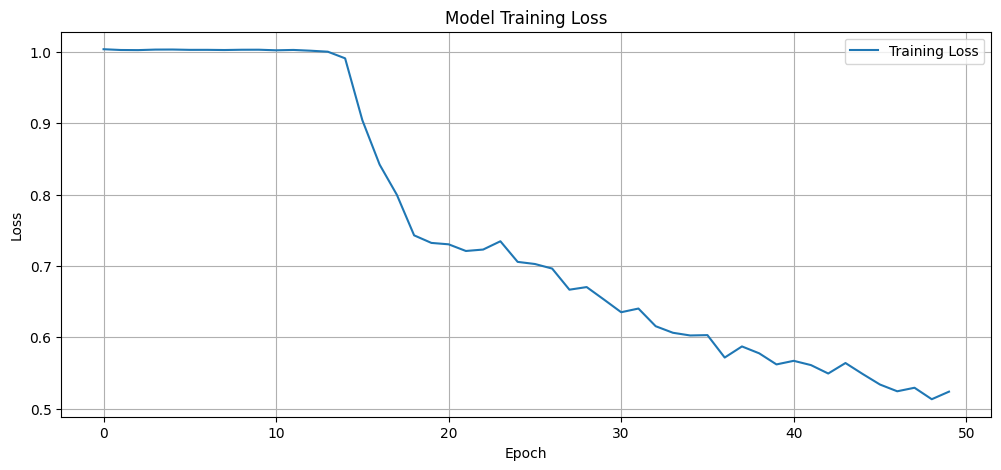

In [15]:
# Train the model
history = vae.fit(
    X_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, None),
    verbose=1
)

# Save the trained model
vae.save(local_data_dir / f"{symbol}_vae_model.keras")
print(f"Model saved to {local_data_dir / f'{symbol}_vae_model'}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 6. Anomaly Detection on Test Data

We evaluate the model on test data to detect anomalous patterns.

In [16]:
# Create sequences from test data
X_test_seq = create_sequences(tm_daily_test, seq_len=seq_len)

# Standardize test data using the same scaler
X_test_seq_scaled = scaler.transform(X_test_seq.reshape(-1, X_test_seq.shape[-1])).reshape(X_test_seq.shape)

print(f"Test sequences shape: {X_test_seq_scaled.shape}")

Test sequences shape: (224, 20, 5)


### 6.1 Calculating Reconstruction Loss

We calculate reconstruction loss for each test sequence to identify anomalies.

In [17]:
# Calculate reconstruction loss for each test sequence
all_loss = []
for x_test in tqdm(X_test_seq_scaled, desc="Evaluating test sequences"):
    x_test = x_test.reshape(1, x_test.shape[0], x_test.shape[1])  # Reshape for model input
    loss = vae.evaluate(x_test, x_test, verbose=0)  # Calculate reconstruction loss
    all_loss.append(loss)

all_loss = np.array(all_loss)

# Save loss values
loss_df = pd.DataFrame(all_loss, index=tm_daily_test.index[-len(all_loss):], columns=['loss'])
loss_df.to_csv(local_data_dir / f"{symbol}_anomaly_scores.csv")
print(f"Anomaly scores saved to {local_data_dir / f'{symbol}_anomaly_scores.csv'}")

print(f"Min loss: {all_loss.min():.4f}, Max loss: {all_loss.max():.4f}, Mean loss: {all_loss.mean():.4f}")

Evaluating test sequences: 100%|██████████| 224/224 [00:41<00:00,  5.45it/s]

Anomaly scores saved to data\CPALL_anomaly_scores.csv
Min loss: 0.0906, Max loss: 8.8611, Mean loss: 0.9310


### 6.2 Visualizing the Distribution of Anomaly Scores

We plot the distribution of reconstruction losses to understand what constitutes an anomaly.

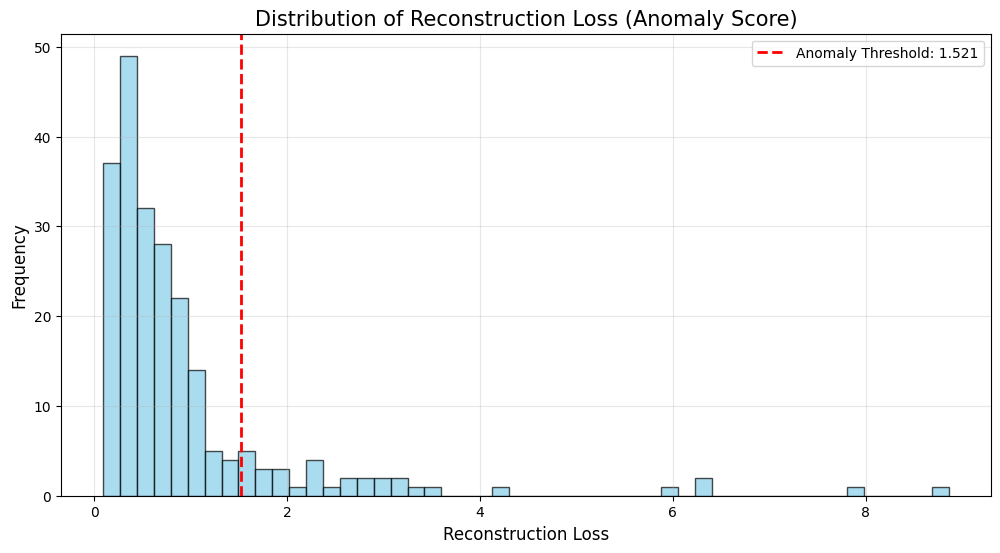

In [28]:
# Plot histogram of loss values
plt.figure(figsize=(12, 6))
plt.hist(all_loss, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Reconstruction Loss (Anomaly Score)', fontsize=15)
plt.xlabel('Reconstruction Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add threshold line for anomaly detection
threshold = all_loss.mean() + all_loss.std() * 0.5
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Anomaly Threshold: {threshold:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(local_data_dir / f"{symbol}_loss_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

### 6.3 Preparing Data for Visualization

In [29]:
# Get the price series for the same period as our anomaly scores
last_plot = daily_last.iloc[-len(all_loss):].copy()
last_plot.index = pd.to_datetime(last_plot.index)

# Create a DataFrame with price and anomaly scores
last_loss = pd.DataFrame(all_loss, index=last_plot.index, columns=['loss'])
last_loss['last'] = last_plot.values

print("Combined data for visualization:")
last_loss.head()

Combined data for visualization:


,loss,last
time,,
2024-06-05,0.276064,58.5
2024-06-06,0.131598,58.0
2024-06-07,0.245837,58.0
2024-06-10,0.333610,57.5
2024-06-11,0.324807,57.0


## 7. Visualization of Results

We visualize the anomaly scores alongside the price chart to identify unusual market behavior.

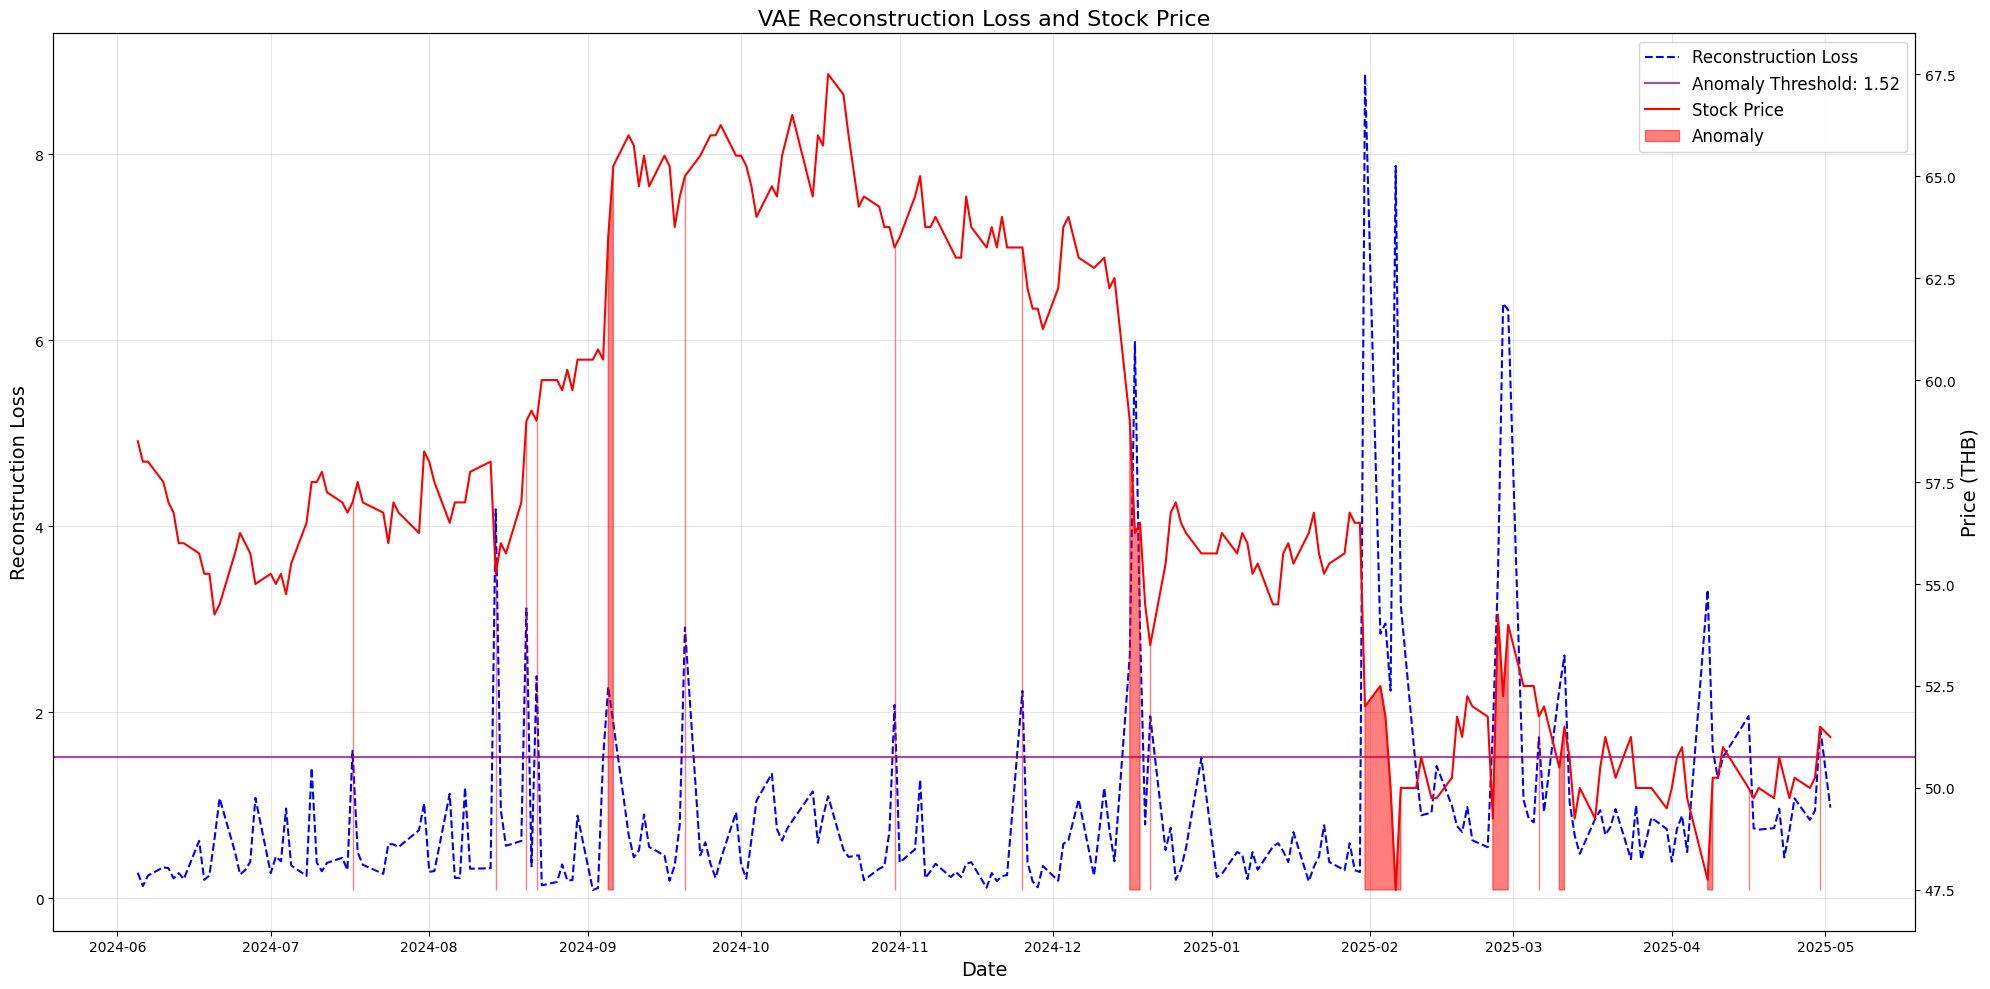

In [30]:
# Define anomaly threshold
anomaly_threshold = threshold
# Create the visualization
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

# Plot loss values
ax.plot(last_loss.index, last_loss['loss'], label='Reconstruction Loss', color='blue', ls='--')
ax.set_title('VAE Reconstruction Loss and Stock Price', fontsize=16)
ax.set_ylabel('Reconstruction Loss', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.axhline(y=anomaly_threshold, color='purple', linestyle='-', alpha=0.7, 
           label=f'Anomaly Threshold: {anomaly_threshold:.2f}')

# Create second y-axis for price
ax2 = ax.twinx()
ax2.plot(last_plot, label='Stock Price', color='red')
ax2.set_ylabel('Price (THB)', fontsize=14)

# Highlight anomalies
ax2.fill_between(
    last_loss.index,
    last_loss['last'].min(), 
    last_loss['last'], 
    alpha=0.5, 
    color='red', 
    where=last_loss['loss'] > anomaly_threshold, 
    label='Anomaly'
)

# Create a combined legend for both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)

# Format the grid
ax.grid(True, alpha=0.3)
plt.tight_layout()

# Save the visualization
plt.savefig(local_data_dir / f"{symbol}_anomaly_detection.png", dpi=300, bbox_inches='tight')
plt.show()

## 8. Quantitative Analysis of Anomalies

We analyze the detected anomalies and their relationship with price movements.

In [31]:
# Identify anomalies based on threshold
last_loss['price_change'] = last_loss['last'].pct_change() * 100
anomalies = last_loss[last_loss['loss'] > anomaly_threshold].copy()
print(f"Detected {len(anomalies)} anomalies out of {len(last_loss)} trading days ({len(anomalies)/len(last_loss):.1%})")


# Compare price volatility
normal_volatility = last_loss[last_loss['loss'] <= anomaly_threshold]['price_change'].std()
anomaly_volatility = anomalies['price_change'].std()

print(f"\nPrice change statistics:")
print(f"Normal days volatility: {normal_volatility:.2f}%")
print(f"Anomaly days volatility: {anomaly_volatility:.2f}%")
print(f"Ratio: {anomaly_volatility/normal_volatility:.2f}x higher during anomalies")

# Show the top 10 anomalies
print("\nTop 10 anomalies by reconstruction loss:")
top_anomalies = last_loss.sort_values('loss', ascending=False).head(10)
top_anomalies[['loss', 'last', 'price_change']]

Detected 30 anomalies out of 224 trading days (13.4%)

Price change statistics:
Normal days volatility: 1.26%
Anomaly days volatility: 4.02%
Ratio: 3.19x higher during anomalies

Top 10 anomalies by reconstruction loss:


,loss,last,price_change
time,,,
2025-01-31,8.861057,52.00,-7.964602
2025-02-06,7.874824,47.50,-5.000000
2025-02-27,6.395037,52.25,-3.686636
2025-02-28,6.326099,54.00,3.349282
2024-12-17,5.981553,56.25,-4.661017
2024-08-14,4.182383,55.25,-4.741379
2025-02-26,3.467457,54.25,10.152284
2025-04-08,3.317027,47.75,-4.020101
2025-02-07,3.152310,50.00,5.263158


## 9. Conclusion and Future Work

Our LSTM-VAE model has successfully identified anomalous trading patterns in CPALL stock data. The anomaly detection system shows potential for identifying unusual market behavior that might indicate significant market events or information asymmetry.

### Key Findings:

1. The model effectively identifies days with abnormal trading patterns based on volume and price features
2. Anomalous trading days often coincide with higher price volatility
3. The VAE reconstruction loss provides a continuous measure of abnormality, allowing for threshold adjustment

### Future Work:

1. Incorporate additional features such as market indices and sector performance
2. Test the model on different time frames (hourly, weekly) for multi-scale anomaly detection
3. Develop an early warning system by predicting future anomalies
4. Optimize hyperparameters for improved anomaly detection accuracy